In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from osm_graph import OsmGraph
%matplotlib inline

In [11]:
df = pd.read_csv("latest_calls.csv")
scoring = pd.read_csv("crime_score.csv")
scoring["offense"] = scoring["offense"].str.upper()
scoring["score"] = 10 - scoring["score"]
df.time = pd.to_datetime(df.time)
df = df.merge(how="left", on="offense", right=scoring)
df.dropna(inplace=True)

In [12]:
df.head()

,Unnamed: 0,x,y,blkaddr,offense,time,score
0,0,-122.300093,37.868250,1900 FOURTH ST,BURGLARY AUTO,2019-04-20 13:00:00,5.0
1,1,-122.259189,37.868714,2300 TELEGRAPH AV,THEFT MISD. (UNDER $950),2019-04-20 15:15:00,5.0
2,2,-122.259260,37.859528,TELEGRAPH AV & STUART ST,VANDALISM,2019-04-20 08:36:00,3.0
3,3,-122.258577,37.864827,2500 TELEGRAPH AV,THEFT MISD. (UNDER $950),2019-04-20 22:42:00,5.0
4,4,-122.270045,37.852304,3100 ADELINE ST,ROBBERY,2019-04-20 13:00:00,6.0


In [13]:
#what is the time between robberies in a given radius?
def distances(x1, y1, x2s, y2s):
    return np.sqrt(np.power((x2s-x1), 2)+np.power((y2s-y1),2))
within2600parker = df[distances(df.iloc[1].x, df.iloc[1].y, df.x, df.y) < .003]
rw2p = within2600parker[within2600parker.offense=="ROBBERY"]
rw2p.time.diff().mean()

Timedelta('15 days 15:18:20')

In [14]:
#what are the counts of crimes in a given radius?
def distances(x1, y1, x2s, y2s):
    return np.sqrt(np.power((x2s-x1), 2)+np.power((y2s-y1),2))
within2600parker = df[distances(df.iloc[0].x, df.iloc[0].y, df.x, df.y) < .003]
gb = within2600parker.groupby("offense")
gb.count()

,Unnamed: 0,x,y,blkaddr,time,score
offense,,,,,,
ALCOHOL OFFENSE,3,3,3,3,3,3
ASSAULT/BATTERY MISD.,3,3,3,3,3,3
BRANDISHING,1,1,1,1,1,1
BURGLARY AUTO,34,34,34,34,34,34
BURGLARY COMMERCIAL,9,9,9,9,9,9
BURGLARY RESIDENTIAL,3,3,3,3,3,3
DISTURBANCE,6,6,6,6,6,6
DOMESTIC VIOLENCE,5,5,5,5,5,5
FRAUD/FORGERY,2,2,2,2,2,2


In [15]:
og = OsmGraph(37.8701457,-122.266438, dist=1500)
nd1 = og.find_node(37.878442, -122.268996)
nd2 = og.find_node(37.867212, -122.263519)
# path = nx.dijkstra_path(og.graph, nd1, nd2)
# g = nx.subgraph(og.graph, path)
# ax = og.draw_graph()
# og.draw_graph(graph=g, ax=ax, edge_color='r', width=2);

In [16]:
og.distance(nd1, nd2)

1334.0886804716001

In [17]:
og.graph.node[275806209]

{'lat': 37.8680731, 'lon': -122.2658603}

In [29]:
help(OsmGraph.draw_graph)

Help on function draw_graph in module osm_graph:

draw_graph(self, figsize=(4, 4), graph=None, ax=None, **kwargs)



In [18]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1= np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    #lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = km * 0.621371
    return miles
def computeCrimes(df, p, time):
    #Number of crimes happening within given given radius from a block
    df["distance"] = haversine(p["lon"], p["lat"], df.x, df.y)
    e = np.exp(28*df["distance"] - 5)
    df["weight"] = 1 - e/(e+1)
    return np.average(df["score"], weights=df["weight"])
def midpoint(e):
    n1, n2 = og.graph.node[e[0]], og.graph.node[e[1]]
    return {"lat" : np.average([n1["lat"], n2["lat"]]), "lon" : np.average([n1["lon"], n2["lon"]])}

In [19]:
for e in og.graph.edges:
    mp = midpoint(e)
    og.graph.edges[e]["midpoint"] = mp
    sc = computeCrimes(df, mp, pd.Timestamp.now())
    og.graph.edges[e]["score"] = sc
    og.graph.edges[e]["cost"] = og.graph.edges[e]["weight"] * sc
    

In [ ]:
for e in og.graph.edges:
    mp = midpoint(e)
    og.graph.edges[e]["midpoint"] = mp
    d = haversine(37.878442, -122.268996, mp["lat"], mp["lon"])
    ex = np.exp(28*d - 5)
    sc = 1 - ex/(ex+1)
    og.graph.edges[e]["score"] = sc
    og.graph.edges[e]["cost"] = og.graph.edges[e]["weight"] * sc
    og.graph.edges[e]["logcost"] = og.graph.edges[e]["weight"] * (1+np.log(1+sc))
    

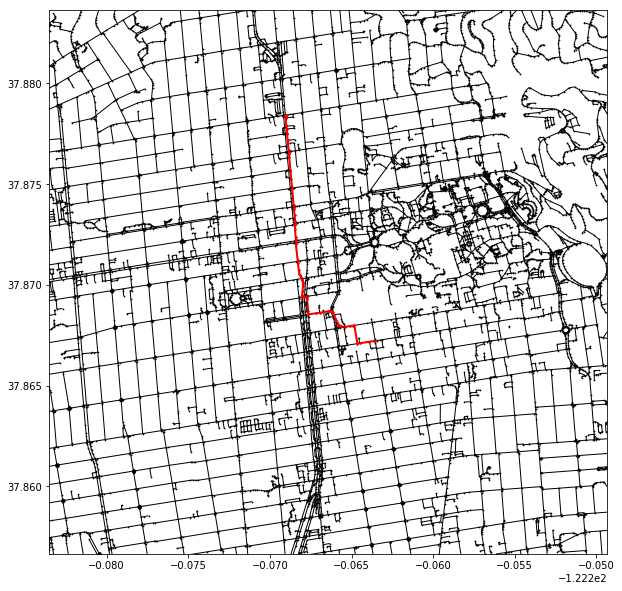

In [20]:
path = nx.dijkstra_path(og.graph, nd1, nd2, weight="cost")
g = nx.subgraph(og.graph, path)
ax = og.draw_graph(edge_color="black", width=1, node_color="black", node_shape=".", figsize=(10, 10))
og.draw_graph(graph=g, ax=ax, edge_color='r', width=2);

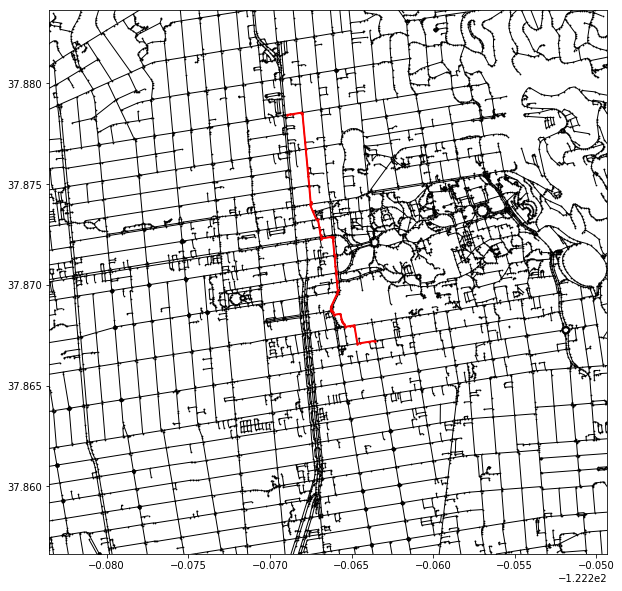

In [22]:
path = nx.dijkstra_path(og.graph, nd1, nd2, weight="score")
g = nx.subgraph(og.graph, path)
ax = og.draw_graph(edge_color="black", width=1, node_color="black", node_shape=".", figsize=(10, 10))
og.draw_graph(graph=g, ax=ax, edge_color='r', width=2);

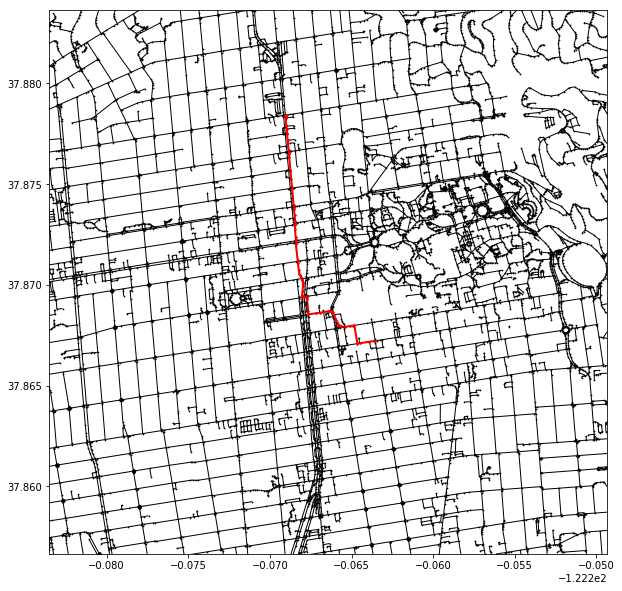

In [23]:
path = nx.dijkstra_path(og.graph, nd1, nd2, weight="cost")
g = nx.subgraph(og.graph, path)
ax = og.draw_graph(edge_color="black", width=1, node_color="black", node_shape=".", figsize=(10, 10))
og.draw_graph(graph=g, ax=ax, edge_color='r', width=2);

In [74]:
a.time()

datetime.time(23, 30)

In [76]:
np.unique(df['offense'])

array(['2ND RESPONSE', 'ALCOHOL OFFENSE', 'ARSON', 'ASSAULT/BATTERY FEL.',
       'ASSAULT/BATTERY MISD.', 'BRANDISHING', 'BURGLARY AUTO',
       'BURGLARY COMMERCIAL', 'BURGLARY RESIDENTIAL', 'DISTURBANCE',
       'DISTURBANCE - NOISE', 'DOMESTIC VIOLENCE', 'FRAUD/FORGERY',
       'GUN/WEAPON', 'IDENTITY THEFT', 'KIDNAPPING', 'MISSING ADULT',
       'MISSING JUVENILE', 'MUNICIPAL CODE', 'NARCOTICS', 'ROBBERY',
       'SEXUAL ASSAULT FEL.', 'SEXUAL ASSAULT MISD.',
       'THEFT FELONY (OVER $950)', 'THEFT FROM AUTO', 'THEFT FROM PERSON',
       'THEFT MISD. (UNDER $950)', 'VANDALISM', 'VEHICLE RECOVERED',
       'VEHICLE STOLEN', 'VICE'], dtype=object)

In [111]:
import inspect
lines = inspect.getsource(og.draw_graph)
print(lines)

    def draw_graph(self, figsize=(4, 4), graph=None, ax=None, **kwargs):
        if ax is None:
            ax = plt.figure(figsize=figsize).add_subplot(111)
        plt.ylim(self.range[0:3:2])
        plt.xlim(self.range[1:4:2])
        nx.draw_networkx(graph or self.graph, pos=self.pos,
            ax=ax, node_size=2, with_labels=False, **kwargs)
        return ax



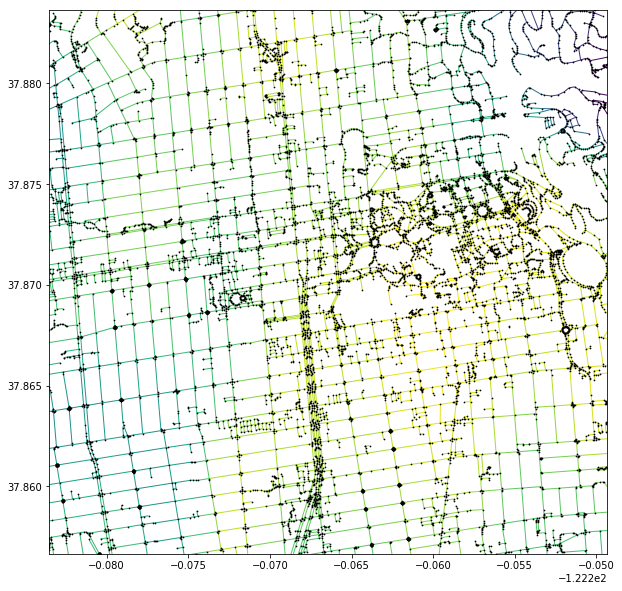

In [24]:
g = nx.subgraph(og.graph, path)
ax = og.draw_graph(edge_color=[og.graph.edges[e]['score'] for e in og.graph.edges], width=1, node_color="black", node_shape=".", figsize=(10, 10))

In [154]:
[og.graph.edges[e]['cost'] for e in og.graph.edges]

[28.214203394782654,
 33.77896194964925,
 27.764157523577303,
 90.31325753525786,
 13.551195919341287,
 12.849630918256404,
 47.501615804808154,
 63.566848916855996,
 103.74374288487014,
 33.36499914687266,
 40.20640087894035,
 33.69487296630045,
 22.99230853838293,
 64.39414445930461,
 26.559845065910775,
 37.68710077794787,
 18.83851426061439,
 6.873793815709864,
 163.52214828279492,
 21.486949542483693,
 28.9796943931662,
 16.469887831122985,
 45.31461047709655,
 34.23816647350518,
 41.363970652701475,
 37.3210863195231,
 36.32775029753789,
 54.1635025715353,
 48.59424034566867,
 43.683491042328896,
 45.35062313793861,
 23.34617638875783,
 176.2586028293686,
 40.95140670163531,
 12.737182934986146,
 13.759942801823403,
 18.306943451750797,
 143.22501504236178,
 42.936771005630206,
 38.76555721825242,
 53.18389766888896,
 22.36251169952705,
 53.78598368927159,
 27.534443260711097,
 63.5705938308703,
 158.56566996333277,
 23.965391204223543,
 34.2180049286257,
 52.54774552759882,
 107

In [152]:
np.average(df["score"].tolist())

4.745025147605511

In [146]:
a = df['weight']
a.tolist

<bound method Series.tolist of 0       0.000000e+00
1       1.079299e-10
2       0.000000e+00
3       5.551115e-14
4       0.000000e+00
5       0.000000e+00
6       0.000000e+00
7       0.000000e+00
8       7.642457e-10
9       0.000000e+00
10      0.000000e+00
11      2.220446e-15
12      0.000000e+00
13      5.906386e-14
14      4.134693e-12
15      3.941292e-14
16      3.879119e-13
17      6.151560e-04
18      0.000000e+00
19      7.760459e-14
20      0.000000e+00
21      1.868583e-11
22      0.000000e+00
23      0.000000e+00
24      1.689525e-08
25      0.000000e+00
26      0.000000e+00
27      6.544654e-12
28      1.740179e-09
29      1.634248e-12
            ...     
4627    0.000000e+00
4628    0.000000e+00
4629    3.552714e-15
4630    0.000000e+00
4631    1.315614e-12
4632    1.490563e-11
4633    0.000000e+00
4634    0.000000e+00
4635    0.000000e+00
4636    3.314138e-11
4637    2.367218e-12
4638    3.552714e-15
4639    1.740179e-09
4640    0.000000e+00
4641    0.000000e+00
464